<a href="https://colab.research.google.com/github/rklepov/hse-cs-ml-2018-2019/blob/homework/09-NLP/HW/hw2/nlp_hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [*HW_texts*](https://github.com/rklepov/hse-cs-ml-2018-2019/blob/homework/09-NLP/HW/HW_texts.ipynb "HW_texts.ipynb") / Задание 1

---


In [1]:
!pip install pymorphy2

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [0]:
import os
import pickle

from joblib import Parallel, delayed
from tqdm import tqdm_notebook

In [4]:
import string
import re

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import WhitespaceTokenizer, TweetTokenizer
from nltk.stem.snowball import SnowballStemmer

import pymorphy2

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Предобработка

### Загрузка данных твиттера

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
!ls -hl data/

total 2.2G
-rw------- 1 root root  24M Sep 16 07:34 negative.csv
-rw------- 1 root root  26M Sep 16 07:34 positive.csv
-rw------- 1 root root 893M Sep 16 07:35 ria_news_2018.pickle
-rw------- 1 root root 1.2G Sep 16 07:34 ria_vk_comments
-rw------- 1 root root  11M Sep 16 07:34 ria_vk_posts
-rw-r--r-- 1 root root  25M Sep 16 10:24 twitter_corpus_lem.dump


In [7]:
tweets_neg = pd.read_csv('data/negative.csv', sep=';', header=-1)
tweets_pos = pd.read_csv('data/positive.csv', sep=';', header=-1)

tweets = tweets_pos[[3,4]].append(tweets_neg[[3,4]])
tweets.columns = ['text', 'target']
tweets.reset_index(drop=True, inplace=True)
tweets['target'] = tweets['target'].replace({-1:0})

print(tweets.shape)
tweets.head(200).tail(5)

(226834, 2)


,text,target
195,RT @olyaolyaTerp: Классно потанцевали сегодня ...,1
196,"@koortain @veshchij_oleg я так понял, что буду...",1
197,"@mindofaddict , регенерация в действии)) Анали...",1
198,"@Yulchik_ya мне говорили, что на труде залили...",1
199,Проводить встречи утром это прикольно — контра...,1


### Очистка текста

1.   Удаление пунктуации
2.   Приведение к нижнему регистру
3.   Токенизация
4.   Лемматизация (или стемминг)
5.   Удаление стоп-слов
6.   Удаление оставшихся слов из одной буквы
7.   Обратное соединение токенов в текст через пробел

Лемматизация с помощью [`pymorphy`](https://pymorphy2.readthedocs.io/en/latest/) занимает продолжительное время (по сравнению, например, со стеммингом), но, предположительно, позволяет провести более качественную подготовку текста для дальнейшего применения при обучении моделей. Поэтому я решил потратить несколько часов на лемматизацию и сохранить её результат в дамп для дальнейшего использования.

In [0]:
def make_punct_remover(pattern = r'[^\w]+'):
    regex = re.compile(pattern)
    return lambda text : regex.sub(' ', text)

def make_lemmatizer(lemmatizer = pymorphy2.MorphAnalyzer()):
    return lambda words : [ lemmatizer.normal_forms(w)[0] for w in words ]

In [0]:
def make_prepare_text(punct_remover, tokenizer, lemmatizer, stopwords):
    def prepare_text(text):
        text = punct_remover(text)    
        words = tokenizer.tokenize(text.lower())
        words = lemmatizer(words)
        words = [ w for w in words if len(w) > 1 and w not in stopwords ]
        return ' '.join(words)
    return prepare_text

Не будем включать частицу *`'не'`* в русский список стоп-слов (она может влиять на тональность текста).

In [0]:
stop_words_ru = [ item for item in stopwords.words('russian') if item != 'не' ]
stop_words_en = stopwords.words('english') 

stop_words = frozenset(stop_words_ru + stop_words_en)

In [0]:
prepare_text = make_prepare_text(make_punct_remover(), TweetTokenizer(), make_lemmatizer(), stop_words)

Пример предобработки текста:

In [12]:
tweets['text'][15]

'@Jyliaalex смотри там случайно в аспирантуру не попади, наука никого до добра не доводила)'

In [13]:
prepare_text(tweets['text'][15])

'jyliaalex смотреть случайно аспирантура не попасть наука никто добро не доводить'

### Предобработка всего корпуса текстов

In [0]:
twitter_corpus = tweets['text'].get_values() 

twitter_dump_path = 'data/twitter_corpus_lem.dump'

if not os.path.exists(twitter_dump_path):
    twitter_corpus_lem = Parallel(n_jobs=-1)(delayed(prepare_text)(tweet) for tweet in tqdm_notebook(twitter_corpus))
    with open(twitter_dump_path, 'wb') as twitter_dump:
        pickle.dump(twitter_corpus_lem, twitter_dump)
else:
    with open(twitter_dump_path, 'rb') as twitter_dump:
        twitter_corpus_lem = pickle.load(twitter_dump)

In [15]:
len(twitter_corpus_lem)

226834

## Модели

In [0]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

[Библиотека визуализации](https://github.com/FUlyankin/hse_texts_do/blob/master/sem_2/visual/ppilif_visual.py "hse_texts_do/ppilif_visual.py at master · FUlyankin/hse_texts_do") от Филиппа `@Ppilif`:

In [0]:
import ppilif_visual as pp

Разделение на обучающую и тестовую выборки.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(twitter_corpus_lem, tweets['target'].get_values(), 
                                                    test_size=0.2, random_state=303)

len(X_train), len(X_test)

(181467, 45367)

### [TF-IDF](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html "sklearn.feature_extraction.text.TfidfVectorizer &#8212; scikit-learn documentation") + [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html "sklearn.linear_model.LogisticRegression &#8212; scikit-learn documentation")

In [0]:
model_tfidf = Pipeline([
            ('vectorizer', TfidfVectorizer(min_df=2, max_df=0.4)),
            ('classifier', LogisticRegression(C=1.))
        ])

model_tfidf.fit(X_train, y_train);

Порог: 0.43860299206242903
Принцип выбора порога: maxf
Процентов теста в бане:  59.33
lift: 1.40 

              precision    recall  f1-score   support

           0       0.79      0.65      0.71     22258
           1       0.71      0.83      0.77     23109

    accuracy                           0.74     45367
   macro avg       0.75      0.74      0.74     45367
weighted avg       0.75      0.74      0.74     45367



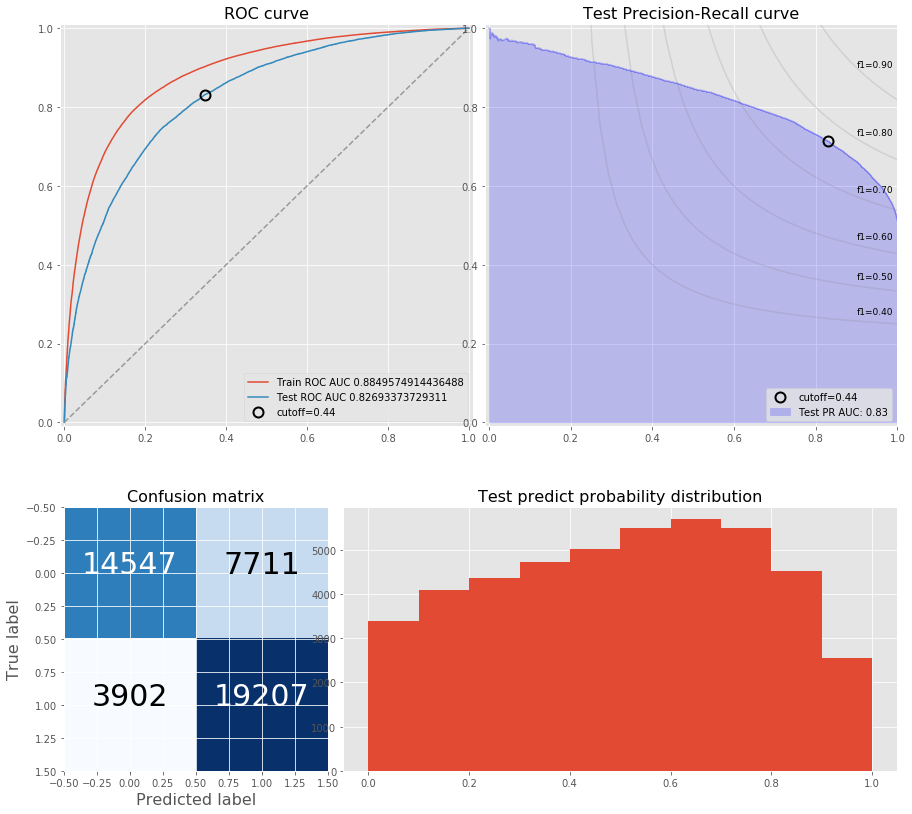

In [20]:
pp.classification_quality_report(model_tfidf, X_train, X_test, y_train, y_test)

### [Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html "sklearn.naive_bayes.MultinomialNB &#8212; scikit-learn documentation")

In [0]:
model_nb = Pipeline([
            ('vectorizer', CountVectorizer()),
            ('classifier', MultinomialNB())
        ])

model_nb.fit(X_train, y_train);

Порог: 0.304881593046542
Принцип выбора порога: maxf
Процентов теста в бане:  60.52
lift: 1.38 

              precision    recall  f1-score   support

           0       0.79      0.63      0.70     22258
           1       0.70      0.83      0.76     23109

    accuracy                           0.73     45367
   macro avg       0.74      0.73      0.73     45367
weighted avg       0.74      0.73      0.73     45367



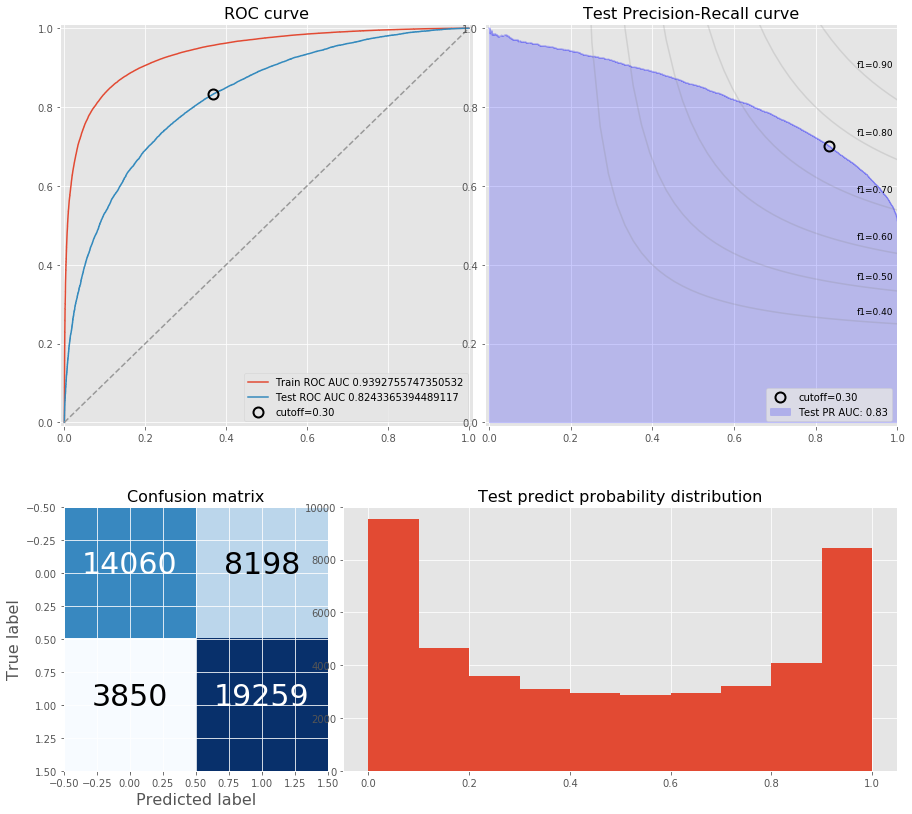

In [22]:
pp.classification_quality_report(model_nb, X_train, X_test, y_train, y_test)

### Сравнение

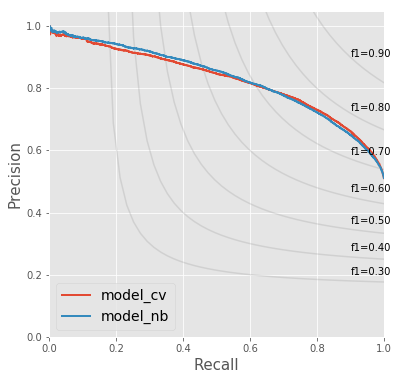

In [23]:
pp.plot_precision_recall_curve_many(
    y_test, figsize=(6 ,6),
    y_pred_probas=[model_tfidf.predict_proba(X_test)[:,-1],
                   model_nb.predict_proba(X_test)[:,-1]],
    labels=['model_cv', 'model_nb'])

## Комментарии ВК

In [0]:
with open('data/ria_vk_comments', 'rb') as f:
    vk_comments = pickle.load(f)

vk_comments = pd.DataFrame(vk_comments)



In [25]:
len(vk_comments)

4040551

In [26]:
vk_comments = vk_comments[['post_id', 'text']]

vk_comments.head(300800).tail(5)

,post_id,text
300795,23631029,"[id320476418|Ваня], карту посмотри"
300796,23631029,"[id387655868|Александр], Может и не прав ! У н..."
300797,23631029,"[id320476418|Ваня], да все может. Хотелось,что..."
300798,23631029,"[id294735913|Александр], УЖАС,у нас в городе т..."
300799,23631029,Балаболы. Назовите мне место съёмки. Я хоть по...


In [0]:
# похоже, надо всё-таки делать стемминг, иначе на 4 млн. комментариев лемматизация pymorphy никогда не закончится
# vk_comments_corpus_lem = Parallel(n_jobs=-1)(delayed(prepare_text)(comment) for comment in tqdm_notebook(vk_comments['text']))